## Training GenAI for Educational App

In [40]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

In [41]:
load_dotenv()

True

In [42]:
model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
response = model.invoke("Hello World!!")
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--2c020381-6974-44f3-855c-cfc87bf21a09-0' usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}}


### Learning Mode for Students

A student should get personalized learning experience based on their profile -
1. class level - class 6, 12th, undergrad, postgrad etc.
2. language - hindi, english, marathi etc

We generate following assets
1. Podcast
2. Mindmap
3. Quiz - interactable and feedback based, sharable, printable
4. Recommended courses from internet
5. A study action plan

A student can enter 
1. a topic name
2. audio recoding of lecture
3. pdf content

This is multi-step, multi-tool AI Agent so will will use `LangGraph` to build the multi-step `Agent` where each node is assigned some specific task and we will try to stream the response back to the user. I am thinking that each node should do its independent job so we can also run these nodes in parallel because they are kind of not tightly coupled with each other's response.

Check this link for parallelization -> https://langchain-ai.github.io/langgraph/tutorials/workflows/#parallelization

In [43]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict

Define the State for our Graph workflow

In [44]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

Nodes for the Graph

In [54]:
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = model.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = model.invoke(f"Write a story about {state['topic']} in 50 words.")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = model.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state.get('story')}\n\n"
    combined += f"JOKE:\n{state.get('joke')}\n\n"
    combined += f"POEM:\n{state.get('poem')}"
    return {"combined_output": combined}

Build the agentic workflow

In [55]:
parallel_builder = StateGraph(State)

Add all the required nodes

In [56]:
# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

Add edges to connect these nodes in meaningful ways.

In [57]:
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

Compile the model.

In [58]:
parallel_workflow = parallel_builder.compile()

Visualize the graph

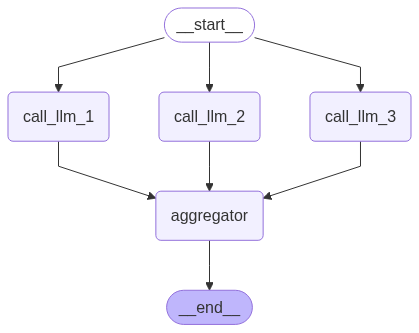

In [59]:
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [60]:
state = parallel_workflow.invoke({"topic": "cats"})

In [61]:
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Whiskers twitched, emerald eyes narrowed. Midnight, a sleek black cat, stalked a laser pointer's crimson dance. Suddenly, a fluffy white blur, Snowball, pounced, batting Midnight aside. A silent war erupted, ending in a tangled purring heap, bathed in the warm glow of the setting sun.

JOKE:
Why did the cat join the Red Cross?

Because it wanted to be a first-aid kit! 

POEM:
A velvet shadow, sleek and sly,
With eyes that hold a moonlit sky.
A silent tread, a graceful leap,
A purring secret, buried deep.

A whiskered face, a twitching nose,
Investigating where it goes,
The dust mote dancing in the sun,
A game begun, a chase is run.

A hunter fierce, a primal grace,
A tiny lion in this place.
A stalk, a pounce, a feathered toy,
Then slumber deep, in blissful joy.

A kneading paw, a rumbling chest,
A comfort given, truly blessed.
A furry friend, a constant near,
Dispelling worries, calming fear.

So let them roam, these creatures free,
A